In [432]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.optimize import minimize
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from scipy.optimize import minimize_scalar
from sympy.printing.latex import print_latex

# stationary dist

In [628]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g, p, C, E, ell  = sp.symbols('a b x g p C E lambda')

In [629]:
# p_i is the stationary distribution for State i
p0    = p1 / (a*(1-p)*(1-sp.exp(-(b-C)/(1-ell))) + a*p*(1-sp.Min(sp.exp(-(b-C-E)/(1-ell)),1)))
p0p   = p1 * (1-a)
p0pp  = p1 * a
p2    = p1*(a/(1-a))
prest = p1*a/(1-2*a)

In [630]:
eq = sp.Eq(p0+p0p+p0pp+prest+p1, 1)
p1_sym = sp.solve(eq, p1)[0]

In [631]:
p1_sym

a*(2*a*p*exp((-C + b)/(lambda - 1)) - 2*a*p*Min(1, exp((-C - E + b)/(lambda - 1))) - 2*a*exp((-C + b)/(lambda - 1)) + 2*a - p*exp((-C + b)/(lambda - 1)) + p*Min(1, exp((-C - E + b)/(lambda - 1))) + exp((-C + b)/(lambda - 1)) - 1)/(3*a**2*p*exp((-C + b)/(lambda - 1)) - 3*a**2*p*Min(1, exp((-C - E + b)/(lambda - 1))) - 3*a**2*exp((-C + b)/(lambda - 1)) + 3*a**2 - 2*a*p*exp((-C + b)/(lambda - 1)) + 2*a*p*Min(1, exp((-C - E + b)/(lambda - 1))) + 2*a*exp((-C + b)/(lambda - 1)) - 1)

In [632]:
p1_me = (1/(a*(1-p)*(1-sp.exp(-(b-C)/(1-ell))) + a*p*(1-sp.Min(sp.exp(-(b-C-E)/(1-ell)),1))) + 1+ (1-a)/(1-2*a))**(-1)
p1_sym.evalf(subs={a:0.3, b:3, ell:0.2, C:1, E:1, p:0.5}), p1_me.evalf(subs={a:0.3, b:3, ell:0.2, C:1, E:1, p:0.5})

(0.146274873287421, 0.146274873287421)

In [633]:
p1_me

1/(1 + 1/(a*p*(1 - Min(1, exp((C + E - b)/(1 - lambda)))) + a*(1 - p)*(1 - exp((C - b)/(1 - lambda)))) + (1 - a)/(1 - 2*a))

## FIXED

In [634]:
# 3 cases for f0
f0i_fixed   = a*C * (p*sp.Min(1,sp.exp(-(b-C-E)/(1-ell))) + (1-p)*sp.exp(-(b-C)/(1-ell)))
f0ii_fixed  = (a**2)*C * (p*(1-sp.Min(1,sp.exp(-(b-C-E)/(1-ell)))) + (1-p)*(1-sp.exp(-(b-C)/(1-ell))))
f0iii_fixed = a*(1-a)*(a+g*(1-a))*C * (p*(1-sp.Min(1,sp.exp(-(b-C-E)/(1-ell)))) + (1-p)*(1-sp.exp(-(b-C)/(1-ell))))
f0iii_fixed

C*a*(1 - a)*(a + g*(1 - a))*(p*(1 - Min(1, exp((C + E - b)/(1 - lambda)))) + (1 - p)*(1 - exp((C - b)/(1 - lambda))))

In [635]:
# explicit for f0 and f1
f0_fixed   = f0i_fixed + f0ii_fixed + f0iii_fixed
f1_fixed   = C*(a+(1-a)*a)

In [636]:
attack_full_fixed  = (p0*f0_fixed + p1*f1_fixed + C*p1*a*(2*a*(1-a)/(1-2*a)))

In [637]:
alphas = np.arange(0.01, 0.5, 0.01)
betas = np.arange(1.01, 5.01, 0.5)
gammas = [0.0, 0.25, 0.5]
p_     = 0.25
E_     = 4
C_     = 1.
g_     = 0.

subs = {C:C_, E:E_, p:p_}

attack_fixed =  attack_full_fixed.subs({p1:p1_sym}).subs(subs)

In [639]:
o_0p    = 1
o_rest = p1*a*(1-a)/(1-2*a)
orphan_full = p0p * o_0p + o_rest

eq1 = sp.Eq(orphan_full.subs({p1:p1_sym}).subs(subs), ell)

In [640]:
selfish_rews = []
for g_ in gammas:
    temp = []
    for i, a_ in tqdm(enumerate(alphas)):
        bestBeta = 100.
        bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
        rew      = attack_fixed.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
        temp.append(1/(1-bestEll)*rew)
    selfish_rews.append(temp)

selfish_rews = np.array(selfish_rews)
selfish_rews.shape

49it [00:01, 25.31it/s]
49it [00:01, 37.14it/s]
49it [00:01, 41.41it/s]


(3, 49)

In [641]:
def EyalSirer(a_, g_):
    num = a_*((1-a_)**2)*(4*a_+g_*(1-2*a_))-(a_**3)
    den = 1 - a_*(1+(2-a_)*a_)
    return num / den

In [642]:
ES_rews = []
for g_ in gammas:
    temp = []
    for i, a_ in tqdm(enumerate(alphas)):
        temp.append(EyalSirer(a_, g_))
    ES_rews.append(temp)
ES_rews = np.array(ES_rews)
ES_rews.shape

49it [00:00, 256580.39it/s]
49it [00:00, 264505.66it/s]
49it [00:00, 283477.10it/s]


(3, 49)

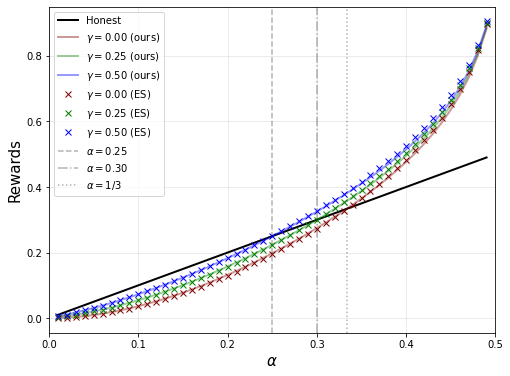

In [643]:
f, ax = plt.subplots(figsize=(8,6))

for ax_ in [ax]:
    ax_.plot(alphas, alphas, label='Honest', color='black', linewidth=2)
    ax_.plot(alphas, selfish_rews[0,:], label=r'$\gamma=0.00$ (ours)', color='maroon', linewidth=2, alpha=0.4)
    ax_.plot(alphas, selfish_rews[1,:], label=r'$\gamma=0.25$ (ours)', color='green', linewidth=2, alpha=0.4)
    ax_.plot(alphas, selfish_rews[2,:], label=r'$\gamma=0.50$ (ours)', color='blue', linewidth=2, alpha=0.4)
    
    ax_.plot(alphas, ES_rews[0,:], label=r'$\gamma=0.00$ (ES)', color='maroon',
             marker='x', linestyle='none')
    ax_.plot(alphas, ES_rews[1,:], label=r'$\gamma=0.25$ (ES)', color='green',
             marker='x', linestyle='none')
    ax_.plot(alphas, ES_rews[2,:], label=r'$\gamma=0.50$ (ES)', color='blue',
             marker='x', linestyle='none')
    ax_.grid(alpha=0.3)

ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'Rewards', size=15)
ax.set_xlim(0,0.5)


ax.axvline(0.25, color='k', alpha=0.3, label=r'$\alpha=0.25$', linestyle='--')
ax.axvline(0.3, color='k', alpha=0.3, label=r'$\alpha=0.30$', linestyle='-.')
ax.axvline(1/3, color='k', alpha=0.3, label=r'$\alpha=1/3$', linestyle='dotted')

ax.legend(loc=2)
plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# selfish profitable

## FIXED

In [644]:
# 3 cases for f0
f0i_fixed   = a*C * (p*sp.Min(1,sp.exp(-(b-C-E)/(1-ell))) + (1-p)*sp.exp(-(b-C)/(1-ell)))
f0ii_fixed  = (a**2)*C * (p*(1-sp.Min(1,sp.exp(-(b-C-E)/(1-ell)))) + (1-p)*(1-sp.exp(-(b-C)/(1-ell))))
f0iii_fixed = a*(1-a)*(a+g*(1-a))*C * (p*(1-sp.Min(1,sp.exp(-(b-C-E)/(1-ell)))) + (1-p)*(1-sp.exp(-(b-C)/(1-ell))))
f0iii_fixed

C*a*(1 - a)*(a + g*(1 - a))*(p*(1 - Min(1, exp((C + E - b)/(1 - lambda)))) + (1 - p)*(1 - exp((C - b)/(1 - lambda))))

In [645]:
# explicit for f0 and f1
f0_fixed   = f0i_fixed + f0ii_fixed + f0iii_fixed
f1_fixed   = C*(a+(1-a)*a)

In [646]:
attack_full_fixed  = (p0*f0_fixed + p1*f1_fixed + C*p1*a*(2*a*(1-a)/(1-2*a)))

## Bernoulli

In [647]:
f0i_bern   = a*E * (p*sp.Min(1,sp.exp(-(b-C-E)/(1-ell))))
f0ii_bern  = (a**2)*E * (p*(1-sp.Min(1,sp.exp(-(b-C-E)/(1-ell)))))
f0iii_bern = a*(1-a)*(a+g*(1-a))*E * (p*(1-sp.Min(1,sp.exp(-(b-C-E)/(1-ell)))))
f0iii_bern

E*a*p*(1 - a)*(1 - Min(1, exp((C + E - b)/(1 - lambda))))*(a + g*(1 - a))

In [648]:
f0_bern   = f0i_bern + f0ii_bern + f0iii_bern
f1_bern   = p*E*(a+(1-a)*a)

In [649]:
attack_full_bern  = (p0*f0_bern + p1*f1_bern + p*E*p1*a*(2*a*(1-a)/(1-2*a)))

## Linear

In [650]:
f0i_lin   = a*p*(sp.Max(0,b-C-E)+(1-ell))*sp.Min(1,sp.exp(-(b-C-E)/(1-ell))) \
            + a*(1-p)*(1-ell+(b-C))*sp.exp(-(b-C)/(1-ell))
f0ii_lin  = a**2 * (p*(1-ell-(sp.Max(0,b-C-E)+1-ell)*sp.Min(1,sp.exp(-(b-C-E)/(1-ell)))) \
            + (1-p)*(1-ell-(1-ell+(b-C))*sp.exp(-(b-C)/(1-ell))))
f0iii_lin = a*((1-a)*(a+g*(1-a))) \
            * (p*(1-ell-(sp.Max(0,b-C-E)+1-ell)*sp.Min(1,sp.exp(-(b-C-E)/(1-ell)))) \
            + (1-p)*(1-ell-(1-ell+(b-C))*sp.exp(-(b-C)/(1-ell))))
f0iii_lin

a*(1 - a)*(a + g*(1 - a))*(p*(-lambda - (-lambda + Max(0, -C - E + b) + 1)*Min(1, exp((C + E - b)/(1 - lambda))) + 1) + (1 - p)*(-lambda - (-C + b - lambda + 1)*exp((C - b)/(1 - lambda)) + 1))

In [651]:
f0iii_lin.subs({p:0, C:0})

a*(1 - a)*(a + g*(1 - a))*(-lambda - (b - lambda + 1)*exp(-b/(1 - lambda)) + 1)

In [652]:
f0_lin = f0i_lin + f0ii_lin + f0iii_lin
f1_lin = (1-ell)*(a + 2*a*(1-a))

In [653]:
attack_full_lin = p0*f0_lin + p1*f1_lin + (1-ell)*p1*a*a*(3-2*a)/(1-2*a)

# threshold

In [142]:
gammas = np.arange(0.001, 1.1, 0.05)
gammas = np.array([0.00, 0.25, 0.5, 0.75])
alphas = np.arange(0.01, 0.50, 0.01)
betas = np.arange(1.01, 5.01, 0.5)

In [143]:
p_ = 0.5
C_ = 1.
E_ = 2.

In [144]:
subs = {C:C_, E:E_, p:p_}

In [145]:
attack_fixed =  attack_full_fixed.subs({p1:p1_sym}).subs(subs)
attack_lin   =  attack_full_lin.subs({p1:p1_sym}).subs(subs)
attack_full = (attack_full_fixed + attack_full_bern + attack_full_lin).subs({p1:p1_sym}).subs(subs)

In [146]:
starting_alphas = .7*np.linspace(0.25, 0.0, len(gammas))

In [151]:
b_res  = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas[alphas>starting_alphas[i]]
#     cand_alphas = alphas
    for a_ in cand_alphas:
        temp = []
        bestBeta = 100.
        bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
        rew      = 1/(1-bestEll)*attack_fixed.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
        if rew > (a_):
            b_res.append(a_)
            break
b_res = np.array(b_res)
b_res.shape

4it [00:02,  1.90it/s]


(4,)

In [155]:
b2_res  = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas[alphas>starting_alphas[i]]
#     cand_alphas = alphas
    for a_ in cand_alphas:
        temp = []
        bestBeta = 100.
        bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
        rew      = 1/(1-bestEll)*attack_full.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
        if rew > (a_*3):
            b2_res.append(a_)
            break
b2_res = np.array(b2_res)
b2_res.shape

4it [00:03,  1.31it/s]


(4,)

In [157]:
l_res  = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas[alphas>starting_alphas[i]]
#     cand_alphas = alphas
    for a_ in cand_alphas:
        temp = []
        # betas can start from 0.
        betas = np.arange(0.01, 5.01, 0.5)
        for b_ in betas:
            ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
            temp.append(attack_lin.subs({a:a_, b:b_, g:g_, ell:ell_}))
        bestBeta = betas[np.argmax(temp)]
        bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
        rew      = 1/(1-bestEll)*attack_lin.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
        if rew > (a_*1.01):
            l_res.append(a_)
            break
l_res = np.array(l_res)
l_res.shape

4it [00:17,  4.30s/it]


(4,)

In [128]:
0.18000000000000002*3

0.54

In [ ]:
f_res  = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas
    for a_ in cand_alphas:
        temp = []
        bestBeta = 100.
        bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
        rew      = 1/(1-bestEll)*attack_full.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
        if rew > (a_*1.0001):
            f_res.append(a_)
            break
f_res = np.array(f_res)
f_res.shape

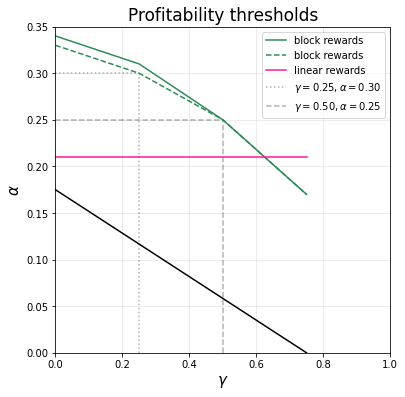

In [159]:
f, ax = plt.subplots(figsize=(6,6))

ax.plot(gammas, b_res, label='block rewards', color='seagreen')
ax.plot(gammas, b2_res, label='block rewards', color='seagreen', linestyle='dashed')
ax.plot(gammas, l_res, label='linear rewards', color='deeppink')
# ax.plot(gammas, f_res, label='total rewards', color='cornflowerblue')
ax.plot(gammas, starting_alphas, color='black')


ax.grid(alpha=0.3)
ax.set_xlabel(r'$\gamma$', size=15)
ax.set_ylabel(r'$\alpha$', size=15)
ax.set_title(r'Profitability thresholds', size=17)

ax.hlines(0.3, xmin=0, xmax=0.25, color='black', linestyles='dotted', alpha=0.3, 
          label=r'$\gamma=0.25,\alpha=0.30$')
ax.vlines(0.25, ymin=0, ymax=0.3, color='black', linestyles='dotted', alpha=0.3)
ax.hlines(0.25, xmin=0, xmax=0.5, color='black', linestyles='--', alpha=0.3, 
          label=r'$\gamma=0.50,\alpha=0.25$')
ax.vlines(0.5, ymin=0, ymax=0.25, color='black', linestyles='--', alpha=0.3)

ax.set_xlim(0,1)
ax.set_ylim(0,.35)

ax.legend()
plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# profit as a function of alpha

In [654]:
alphas = np.arange(0.01, 0.50, 0.01)
betas = np.arange(1.01, 5.01, 0.5)
gammas = [0.0, 0.5, 1.0]
p_     = 0.25
E_     = 4
C_     = 1.
g_     = 0.

In [655]:
subs = {C:C_, E:E_, p:p_}

In [656]:
attack_fixed =  attack_full_fixed.subs({p1:p1_sym}).subs(subs)
attack_lin   =  attack_full_lin.subs({p1:p1_sym}).subs(subs)
attack_full = (attack_full_fixed + attack_full_bern + attack_full_lin).subs({p1:p1_sym}).subs(subs)

In [657]:
o_0p    = 1
o_rest = p1*a*(1-a)/(1-2*a)
orphan_full = p0p * o_0p + o_rest

eq1 = sp.Eq(orphan_full.subs({p1:p1_sym}).subs(subs), ell)

In [658]:
selfish_rews = []
linear_rews  = []
total_rews   = []
# for i, a_ in tqdm(enumerate(alphas)):
for i, a_ in enumerate(alphas):
    bestBeta = 100.
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = (1/(1-bestEll))*attack_fixed.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    selfish_rews.append(rew)

    temp = []
    for b_ in betas:
        ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
        temp.append((1/(1-ell_))*attack_lin.subs({a:a_, b:b_, g:g_, ell:ell_}))
    bestBeta = betas[np.argmax(temp)]
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = (1/(1-bestEll))*attack_lin.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    linear_rews.append(rew)
    print(a_, bestBeta)
    
    temp = []
    for b_ in betas:
        ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
        temp.append((1/(1-ell_))*attack_full.subs({a:a_, b:b_, g:g_, ell:ell_}))
    bestBeta = betas[np.argmax(temp)]
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = (1/(1-bestEll))*attack_full.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    total_rews.append(rew)

selfish_rews = np.array(selfish_rews)
linear_rews = np.array(linear_rews)
total_rews = np.array(total_rews)
selfish_rews.shape, linear_rews.shape, total_rews.shape

0.01 1.01
0.02 1.01
0.03 1.01
0.04 1.01
0.05 1.01
0.060000000000000005 1.01
0.06999999999999999 1.01
0.08 1.01
0.09 1.01
0.09999999999999999 1.01
0.11 1.01
0.12 1.01
0.13 1.01
0.14 1.01
0.15000000000000002 1.01
0.16 1.01
0.17 1.51
0.18000000000000002 1.51
0.19 1.51
0.2 1.51
0.21000000000000002 1.51
0.22 1.51
0.23 1.51
0.24000000000000002 1.51
0.25 1.51
0.26 1.51
0.27 1.51
0.28 1.51
0.29000000000000004 1.51
0.3 1.51
0.31 1.51
0.32 2.01
0.33 2.01
0.34 2.01
0.35000000000000003 2.01
0.36000000000000004 2.01
0.37 2.01
0.38 2.01
0.39 2.51
0.4 2.51
0.41000000000000003 2.51
0.42000000000000004 2.51
0.43 3.01
0.44 3.01
0.45 3.01
0.46 3.51
0.47000000000000003 3.51
0.48000000000000004 3.51
0.49 4.01


((49,), (49,), (49,))

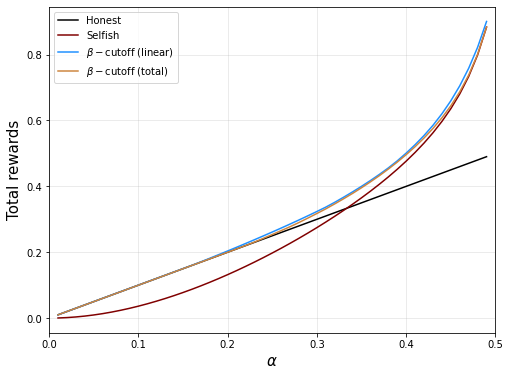

In [659]:
f, ax = plt.subplots(figsize=(8,6))

for ax_ in [ax]:
    ax_.plot(alphas, alphas, label='Honest', color='black')
    ax_.plot(alphas, selfish_rews, label='Selfish', color='maroon')
    ax_.plot(alphas, linear_rews, label=r'$\beta-$cutoff (linear)', color='dodgerblue')
    ax_.plot(alphas, total_rews/3, label=r'$\beta-$cutoff (total)', color='peru')
    ax_.grid(alpha=0.3)

ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'Total rewards', size=15)
ax.set_xlim(0,0.5)
# ax.set_ylim(0,1.)
ax.legend(loc=2)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [660]:
alphas = np.arange(0.01, 0.50, 0.01)
betas = np.arange(1.01, 5.01, 0.5)
gammas = [0.0, 0.5, 1.0]
p_     = 0.25
E_     = 4
C_     = 1.
g_     = 0.

In [661]:
subs = {C:C_, E:E_, p:p_}

In [662]:
attack_fixed =  attack_full_fixed.subs({p1:p1_sym}).subs(subs)
attack_lin   =  attack_full_lin.subs({p1:p1_sym}).subs(subs)
attack_both  = (attack_full_fixed + attack_full_lin).subs({p1:p1_sym}).subs(subs)
attack_full = (attack_full_fixed + attack_full_bern + attack_full_lin).subs({p1:p1_sym}).subs(subs)

In [663]:
o_0p    = 1
o_rest = p1*a*(1-a)/(1-2*a)
orphan_full = p0p * o_0p + o_rest

eq1 = sp.Eq(orphan_full.subs({p1:p1_sym}).subs(subs), ell)

In [664]:
selfish_rews = []
linear_rews  = []
total_rews   = []
# for i, a_ in tqdm(enumerate(alphas)):
for i, a_ in enumerate(alphas):
    bestBeta = 100.
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = (1/(1-bestEll))*attack_fixed.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    selfish_rews.append(rew)

    temp = []
    for b_ in betas:
        ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
        temp.append((1/(1-ell_))*attack_lin.subs({a:a_, b:b_, g:g_, ell:ell_}))
    bestBeta = betas[np.argmax(temp)]
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = (1/(1-bestEll))*attack_lin.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    linear_rews.append(rew)
    print(a_, bestBeta)
    
    temp = []
    for b_ in betas:
        ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
        temp.append((1/(1-ell_))*attack_both.subs({a:a_, b:b_, g:g_, ell:ell_}))
    bestBeta = betas[np.argmax(temp)]
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = (1/(1-bestEll))*attack_both.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    total_rews.append(rew)

selfish_rews = np.array(selfish_rews)
linear_rews = np.array(linear_rews)
total_rews = np.array(total_rews)
selfish_rews.shape, linear_rews.shape, total_rews.shape

0.01 1.01
0.02 1.01
0.03 1.01
0.04 1.01
0.05 1.01
0.060000000000000005 1.01
0.06999999999999999 1.01
0.08 1.01
0.09 1.01
0.09999999999999999 1.01
0.11 1.01
0.12 1.01
0.13 1.01
0.14 1.01
0.15000000000000002 1.01
0.16 1.01
0.17 1.51
0.18000000000000002 1.51
0.19 1.51
0.2 1.51
0.21000000000000002 1.51
0.22 1.51
0.23 1.51
0.24000000000000002 1.51
0.25 1.51
0.26 1.51
0.27 1.51
0.28 1.51
0.29000000000000004 1.51
0.3 1.51
0.31 1.51
0.32 2.01
0.33 2.01
0.34 2.01
0.35000000000000003 2.01
0.36000000000000004 2.01
0.37 2.01
0.38 2.01
0.39 2.51
0.4 2.51
0.41000000000000003 2.51
0.42000000000000004 2.51
0.43 3.01
0.44 3.01
0.45 3.01
0.46 3.51
0.47000000000000003 3.51
0.48000000000000004 3.51
0.49 4.01


((49,), (49,), (49,))

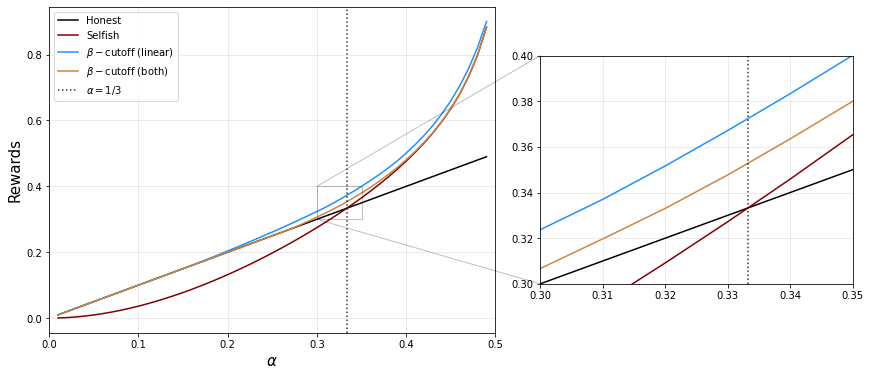

In [665]:
f, ax = plt.subplots(figsize=(8,6))


axins = ax.inset_axes(
    [1.1, 0.15, 0.7, 0.7],
    xlim=(.3, .35), ylim=(0.3, 0.4))

ax.indicate_inset_zoom(axins, edgecolor="black", label=None, alpha=0.25)


for ax_ in [ax, axins]:
    ax_.plot(alphas, alphas, label='Honest', color='black')
    ax_.plot(alphas, selfish_rews, label='Selfish', color='maroon')
    ax_.plot(alphas, linear_rews, label=r'$\beta-$cutoff (linear)', color='dodgerblue')
    ax_.plot(alphas, total_rews/2, label=r'$\beta-$cutoff (both)', color='peru')
    ax_.grid(alpha=0.3)
    ax_.axvline(1/3, color='k', alpha=0.8, label=r'$\alpha=1/3$', linestyle='dotted')

ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'Rewards', size=15)
ax.set_xlim(0,0.5)

ax.legend(loc=2)
plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [666]:
alphas = np.arange(0.01, 0.50, 0.01)
betas = np.arange(1.01, 5.01, 0.5)
gammas = [0.0, 0.5, 1.0]
p_     = 0.25
E_     = 4
C_     = 1.
g_     = 0.

In [667]:
subs = {C:C_, E:E_, p:p_}

In [668]:
attack_fixed = attack_full_fixed.subs({p1:p1_sym}).subs(subs)
attack_lin   = attack_full_lin.subs({p1:p1_sym}).subs(subs)
attack_bern  = attack_full_bern.subs({p1:p1_sym}).subs(subs)
attack_full  = (attack_full_fixed + attack_full_bern + attack_full_lin).subs({p1:p1_sym}).subs(subs)

In [669]:
o_0p    = 1
o_rest = p1*a*(1-a)/(1-2*a)
orphan_full = p0p * o_0p + o_rest

eq1 = sp.Eq(orphan_full.subs({p1:p1_sym}).subs(subs), ell)

In [670]:
selfish_rews = []
linear_rews  = []
bern_rews    = []
total_rews   = []
# for i, a_ in tqdm(enumerate(alphas)):
for i, a_ in enumerate(alphas):
    bestBeta = 100.
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = (1/(1-bestEll))*attack_full.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    selfish_rews.append(rew)

    temp = []
    for b_ in betas:
        ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
        temp.append((1/(1-ell_))*attack_lin.subs({a:a_, b:b_, g:g_, ell:ell_}))
    bestBeta = betas[np.argmax(temp)]
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = (1/(1-bestEll))*attack_full.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    linear_rews.append(rew)
    print(a_, bestBeta)
    
    temp = []
    for b_ in betas:
        ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
        temp.append((1/(1-ell_))*attack_bern.subs({a:a_, b:b_, g:g_, ell:ell_}))
    bestBeta = betas[np.argmax(temp)]
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = (1/(1-bestEll))*attack_full.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    bern_rews.append(rew)
    
    temp = []
    for b_ in betas:
        ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
        temp.append((1/(1-ell_))*attack_full.subs({a:a_, b:b_, g:g_, ell:ell_}))
    bestBeta = betas[np.argmax(temp)]
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = (1/(1-bestEll))*attack_full.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    total_rews.append(rew)

selfish_rews = np.array(selfish_rews)
linear_rews = np.array(linear_rews)
bern_rews = np.array(bern_rews)
total_rews = np.array(total_rews)
selfish_rews.shape, linear_rews.shape, total_rews.shape

0.01 1.01
0.02 1.01
0.03 1.01
0.04 1.01
0.05 1.01
0.060000000000000005 1.01
0.06999999999999999 1.01
0.08 1.01
0.09 1.01
0.09999999999999999 1.01
0.11 1.01
0.12 1.01
0.13 1.01
0.14 1.01
0.15000000000000002 1.01
0.16 1.01
0.17 1.51
0.18000000000000002 1.51
0.19 1.51
0.2 1.51
0.21000000000000002 1.51
0.22 1.51
0.23 1.51
0.24000000000000002 1.51
0.25 1.51
0.26 1.51
0.27 1.51
0.28 1.51
0.29000000000000004 1.51
0.3 1.51
0.31 1.51
0.32 2.01
0.33 2.01
0.34 2.01
0.35000000000000003 2.01
0.36000000000000004 2.01
0.37 2.01
0.38 2.01
0.39 2.51
0.4 2.51
0.41000000000000003 2.51
0.42000000000000004 2.51
0.43 3.01
0.44 3.01
0.45 3.01
0.46 3.51
0.47000000000000003 3.51
0.48000000000000004 3.51
0.49 4.01


((49,), (49,), (49,))

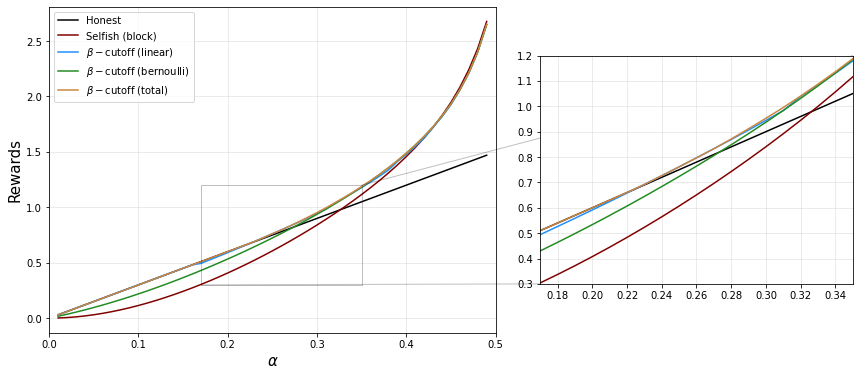

In [671]:
f, ax = plt.subplots(figsize=(8,6))


axins = ax.inset_axes(
    [1.1, 0.15, 0.7, 0.7],
    xlim=(.17, .35), ylim=(0.3, 1.2))

ax.indicate_inset_zoom(axins, edgecolor="black", label=None, alpha=0.25)


for ax_ in [ax, axins]:
    ax_.plot(alphas, alphas*3, label='Honest', color='black')
    ax_.plot(alphas, selfish_rews, label='Selfish (block)', color='maroon')
    ax_.plot(alphas, linear_rews, label=r'$\beta-$cutoff (linear)', color='dodgerblue')
    ax_.plot(alphas, bern_rews, label=r'$\beta-$cutoff (bernoulli)', color='forestgreen')
    ax_.plot(alphas, total_rews, label=r'$\beta-$cutoff (total)', color='peru')
    ax_.grid(alpha=0.3)
#     ax_.axvline(1/3, color='k', alpha=0.8, label=r'$\alpha=1/3$', linestyle='dotted')

ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'Rewards', size=15)
ax.set_xlim(0,0.5)

ax.legend(loc=2)
plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# threshold

In [348]:
gammas = np.arange(0.001, 1.1, 0.1)
# gammas = np.array([0.00, 0.25, 0.5, 0.75])
alphas = np.arange(0.01, 0.50, 0.01)
betas = np.arange(1.01, 5.01, 0.5)

In [533]:
p_     = 0.25
E_     = .5
C_     = 1.

In [502]:
subs = {C:C_, E:E_, p:p_}

In [503]:
attack_fixed =  attack_full_fixed.subs({p1:p1_sym}).subs(subs)
attack_lin   =  attack_full_lin.subs({p1:p1_sym}).subs(subs)
attack_both  = (attack_full_fixed + attack_full_lin).subs({p1:p1_sym}).subs(subs)
attack_full  = (attack_full_fixed + attack_full_bern + attack_full_lin).subs({p1:p1_sym}).subs(subs)

In [504]:
o_0p    = 1
o_rest = p1*a*(1-a)/(1-2*a)
orphan_full = p0p * o_0p + o_rest

eq1 = sp.Eq(orphan_full.subs({p1:p1_sym}).subs(subs), ell)

In [505]:
starting_alphas = .7*np.linspace(0.25, 0.0, len(gammas))

In [506]:
b_res  = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas[alphas>starting_alphas[i]]
#     cand_alphas = alphas
    for a_ in cand_alphas:
        temp = []
        bestBeta = 100.
        bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
        rew      = 1/(1-bestEll)*attack_fixed.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
        if rew > (a_):
            b_res.append(a_)
            break
b_res = np.array(b_res)
b_res.shape

11it [00:04,  2.37it/s]


(11,)

In [469]:
betas

array([1.01, 1.51, 2.01, 2.51, 3.01, 3.51, 4.01, 4.51])

In [508]:
def objective(b_val, a_val, g_val):
    ell_sol = sp.nsolve(eq1.subs({a: a_val, b: b_val, g: g_val}), ell, 0.1)
    res_val = attack_both.subs({a: a_val, b: b_val, g: g_val, ell: ell_sol})
    return -float(res_val)

b_bounds = (1.001, 10.0)  # adjust as needed for your problem

In [509]:
bo_res  = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas[alphas>starting_alphas[i]]
#     cand_alphas = alphas
    for a_ in cand_alphas:
        result = minimize_scalar(objective, bounds=b_bounds, method='bounded', args=(a_, g_), options={'xatol': 0.2})
        bestBeta = result.x
        bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
        rew      = 1/(1-bestEll)*attack_both.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
        if rew > (a_*(1+C_)):
            bo_res.append(a_)
            break
bo_res = np.array(bo_res)
bo_res.shape

11it [00:21,  1.99s/it]


(11,)

In [534]:
def objective(b_val, a_val, g_val):
    ell_sol = sp.nsolve(eq1.subs({a: a_val, b: b_val, g: g_val}), ell, 0.1)
    res_val = attack_full.subs({a: a_val, b: b_val, g: g_val, ell: ell_sol})
    return -float(res_val)

b_bounds = (1.001, 10.0)  # adjust as needed for your problem

In [535]:
f_res  = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas[alphas>starting_alphas[i]]
#     cand_alphas = alphas
    for a_ in cand_alphas:
        result = minimize_scalar(objective, bounds=b_bounds, method='bounded', args=(a_, g_), options={'xatol': 0.2})
        bestBeta = result.x
        bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
        rew      = 1/(1-bestEll)*attack_full.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
        if rew > (a_*(1+C_+p_*E_)):
            f_res.append(a_)
            break
f_res = np.array(f_res)
f_res.shape

11it [00:03,  3.30it/s]


(11,)

In [514]:
def objective(b_val, a_val, g_val):
    ell_sol = sp.nsolve(eq1.subs({a: a_val, b: b_val, g: g_val}), ell, 0.1)
    res_val = attack_lin.subs({a: a_val, b: b_val, g: g_val, ell: ell_sol})
    return -float(res_val)

b_bounds = (1.001, 10.0)  # adjust as needed for your problem

In [515]:
l_res  = []
for i, g_ in tqdm(enumerate(gammas)):
#     cand_alphas = alphas[alphas>starting_alphas[i]]
    cand_alphas = alphas
    for a_ in cand_alphas:
        result = minimize_scalar(objective, bounds=b_bounds, method='bounded', args=(a_, g_), options={'xatol': 0.2})
        bestBeta = result.x
        bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
        rew      = 1/(1-bestEll)*attack_lin.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
        if rew > (a_):
            l_res.append(a_)
            break
l_res = np.array(l_res)
l_res.shape

11it [00:07,  1.46it/s]


(11,)

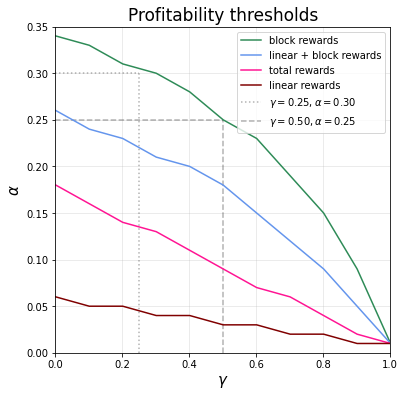

In [541]:
f, ax = plt.subplots(figsize=(6,6))

ax.plot(gammas, b_res, label='block rewards', color='seagreen')
ax.plot(gammas, bo_res, label='linear + block rewards', color='cornflowerblue')
ax.plot(gammas, f_res, label='total rewards', color='deeppink')
ax.plot(gammas, l_res, label='linear rewards', color='maroon')
# ax.plot(gammas, starting_alphas, color='black')


ax.grid(alpha=0.3)
ax.set_xlabel(r'$\gamma$', size=15)
ax.set_ylabel(r'$\alpha$', size=15)
ax.set_title(r'Profitability thresholds', size=17)

ax.hlines(0.3, xmin=0, xmax=0.25, color='black', linestyles='dotted', alpha=0.3, 
          label=r'$\gamma=0.25,\alpha=0.30$')
ax.vlines(0.25, ymin=0, ymax=0.3, color='black', linestyles='dotted', alpha=0.3)
ax.hlines(0.25, xmin=0, xmax=0.5, color='black', linestyles='--', alpha=0.3, 
          label=r'$\gamma=0.50,\alpha=0.25$')
ax.vlines(0.5, ymin=0, ymax=0.25, color='black', linestyles='--', alpha=0.3)

ax.set_xlim(0,1)
ax.set_ylim(0,.35)

ax.legend()
plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# matching matt

In [567]:
def Carlsten(alpha, beta, gamma=0):
    num1 = 1 + (beta * np.power(1-alpha,2) * (1-gamma))
    den1 = np.exp(beta) - 1
    exp1 = num1 / den1
    
    exp2 = exp1 + (5 * alpha) + (np.power(1-alpha, 2) * gamma) 
    exp3 = (2 * np.power(alpha, 2)) / (1-2 * alpha) - (2 * np.power(alpha,2))
    
    exp4 = exp2 + exp3
    
    num2 = alpha * (1-2*alpha) * (1 - np.exp(-beta))
    den2 = 1 - 2 * np.exp(-beta) * alpha - 3 * (1 - np.exp(-beta)) * np.power(alpha,2)
    
    exp5 = num2 / den2
    
    return exp4 * exp5

In [585]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g, p, E, ell  = sp.symbols('a b x g p E lambda')

In [586]:
# ps should be the same
p0    = p1 / (a*(1-sp.exp(-b/(1-ell))))
p0p   = p1 * (1-a)
p0pp  = p1 * a
prest = p1*a/(1-2*a)

In [587]:
p0

p_1/(a*(1 - exp(-b/(1 - lambda))))

In [588]:
eq = sp.Eq(p0+p0p+p0pp+prest+p1, 1)
p1_sym = sp.solve(eq, p1)[0]

In [589]:
p1_sym

a*(2*a*exp(b/(lambda - 1)) - 2*a - exp(b/(lambda - 1)) + 1)/(-3*a**2 + a*(3*a - 2)*exp(b/(lambda - 1)) + 1)

In [590]:
p1_me = (1/(a*(1-sp.exp(-b/(1-ell)))) + 1+ (1-a)/(1-2*a))**(-1)
p1_sym.evalf(subs={a:0.3, b:1, ell:0.2}), p1_me.evalf(subs={a:0.3, b:1, ell:0.2})

(0.134737530842340, 0.134737530842340)

In [591]:
p1_me

1/(1 + (1 - a)/(1 - 2*a) + 1/(a*(1 - exp(-b/(1 - lambda)))))

In [592]:
f0i   = a*(b+1-ell)*sp.exp(-b/(1-ell)) 
f0ii  = a**2*(1-ell - (b+1-ell)*sp.exp(-b/(1-ell)))
f0iii = a*(1-a)*(a+g*(1-a))*(1-ell - (b+1-ell)*sp.exp(-b/(1-ell)))
f0iii

a*(1 - a)*(a + g*(1 - a))*(-lambda - (b - lambda + 1)*exp(-b/(1 - lambda)) + 1)

In [593]:
f0 = f0i + f0ii + f0iii
f0

a**2*(-lambda - (b - lambda + 1)*exp(-b/(1 - lambda)) + 1) + a*(1 - a)*(a + g*(1 - a))*(-lambda - (b - lambda + 1)*exp(-b/(1 - lambda)) + 1) + a*(b - lambda + 1)*exp(-b/(1 - lambda))

In [594]:
# REAL
f1 = (1-ell)*(a + 2*a*(1-a))
f1

(1 - lambda)*(2*a*(1 - a) + a)

In [595]:
full = p0*f0 + p1*f1 + (1-ell)*p1*a*a*(3-2*a)/(1-2*a)
final = sp.simplify(full.evalf(subs={p1:p1_me}))
finalLambda = sp.lambdify((a, b, g, ell), final, )
finalLambda

<function _lambdifygenerated(a, b, g, lambda_)>

In [562]:
a_ = 0.2
b_ = 2.
g_ = 1.

In [563]:
subs = {a:a_, b:b_, g:g_}
o_rest = p1*a*(1-a)/(1-2*a)
orphan_full = p0p + o_rest

eq1 = sp.Eq(orphan_full.subs({p1:p1_sym}).subs(subs), ell)
ell_ = sp.nsolve(eq1, ell, 0.1)
ell_

0.0754249124058772

In [566]:
finalLambda(a_, float(b_*(1-ell_)), g_, float(ell_))/(1-ell_),  Carlsten(a_, b_, g_), \
finalLambda(a_, float(b_*(1-ell_)), g_, float(ell_))/(1-ell_) - Carlsten(a_, b_, g_)

(0.107487120457712, 0.10748712045771223, 0)

In [576]:
alphas = [0.2, 0.3, 0.4]
betas  = np.arange(0.1, 10, 0.01)
gammas = [0., 0.5, 1.]

resTheir = []
for a_ in alphas:
    temp = []
    for g_ in gammas:
        temp.append(Carlsten(a_, betas, g_))
    resTheir.append(temp)
resTheir = np.array(resTheir)
resTheir.shape

(3, 3, 990)

In [600]:
betas_OURS  = np.arange(0.1, 10, 0.5)

In [601]:
resOurs = []
for a_ in tqdm(alphas):
    temp = []
    for g_ in gammas:
        temp2 = []
        for b_ in betas_OURS:
            subs = {a:a_, b:b_, g:g_} 
            eq1 = sp.Eq(orphan_full.subs({p1:p1_sym}).subs(subs), ell)
            ell_ = sp.nsolve(eq1, ell, 0.1)
            rew = finalLambda(a_, float(b_*(1-ell_)), g_, float(ell_))/(1-ell_)
            temp2.append(rew)
        temp.append(temp2)
    resOurs.append(temp)
resOurs = np.array(resOurs)
resOurs.shape

100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


(3, 3, 20)

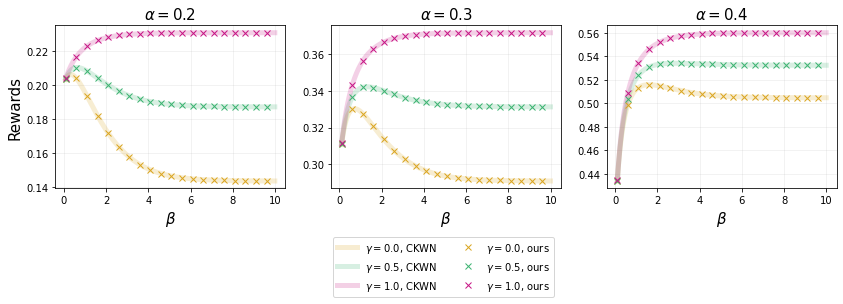

In [609]:
f, axarr = plt.subplots(ncols=3, figsize=(14,3))

colors = ['goldenrod', 'mediumseagreen', 'mediumvioletred']
for j in range(3):
    ax = axarr[j]
    for i in [0, 1, 2]:
        ax.plot(betas, resTheir[j,i], color=colors[i], alpha=0.2,
                label='$\gamma={:0.1f}$, CKWN'.format(gammas[i]), 
                linestyle='-', linewidth=5)
    for i in [0, 1, 2]:
        ax.plot(betas_OURS, resOurs[j,i], color=colors[i], alpha=1, marker='x',
                label='$\gamma={:0.1f}$, ours'.format(gammas[i]), linestyle='none')


for ax in axarr:
    ax.grid(alpha=0.2)
    ax.set_xlabel(r'$\beta$', size=15)

axarr[0].set_ylabel(r'Rewards', size=15)
axarr[0].set_title(r'$\alpha=0.2$', size=15)
axarr[1].set_title(r'$\alpha=0.3$', size=15)
axarr[2].set_title(r'$\alpha=0.4$', size=15)

handles, labels = axarr[0].get_legend_handles_labels()
f.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.51, -0.4), ncol=2)

plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

# Bernoulli

In [680]:
alphas = np.arange(0.01, 0.50, 0.01)
betas = np.arange(1.01, 5.01, 0.5)
gammas = [0.0, 0.5, 1.0]
p_     = 0.25
E_     = 4
C_     = 1.
g_     = 0.

In [681]:
subs = {C:C_, E:E_, p:p_}

In [682]:
attack_fixed =  attack_full_fixed.subs({p1:p1_sym}).subs(subs)
attack_bern  =  attack_full_bern.subs({p1:p1_sym}).subs(subs)
attack_full = (attack_full_fixed + attack_full_bern + attack_full_lin).subs({p1:p1_sym}).subs(subs)

In [684]:
o_0p    = 1
o_rest = p1*a*(1-a)/(1-2*a)
orphan_full = p0p * o_0p + o_rest

eq1 = sp.Eq(orphan_full.subs({p1:p1_sym}).subs(subs), ell)

In [685]:
selfish_rews = []
bern_rews    = []
total_rews   = []
for i, a_ in enumerate(alphas):
    bestBeta = 100.
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = (1/(1-bestEll))*attack_fixed.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    selfish_rews.append(rew)

    temp = []
    for b_ in betas:
        ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
        temp.append((1/(1-ell_))*attack_bern.subs({a:a_, b:b_, g:g_, ell:ell_}))
    bestBeta = betas[np.argmax(temp)]
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = (1/(1-bestEll))*attack_bern.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    bern_rews.append(rew)
    print(a_, bestBeta)
    
    temp = []
    for b_ in betas:
        ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
        temp.append((1/(1-ell_))*attack_full.subs({a:a_, b:b_, g:g_, ell:ell_}))
    bestBeta = betas[np.argmax(temp)]
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = (1/(1-bestEll))*attack_full.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    total_rews.append(rew)

selfish_rews = np.array(selfish_rews)
bern_rews    = np.array(bern_rews)
total_rews   = np.array(total_rews)
selfish_rews.shape, linear_rews.shape, total_rews.shape

0.01 4.51
0.02 4.51
0.03 4.51
0.04 4.51
0.05 4.51
0.060000000000000005 4.51
0.06999999999999999 4.51
0.08 4.51
0.09 4.51
0.09999999999999999 4.51
0.11 4.51
0.12 4.51
0.13 4.51
0.14 4.51
0.15000000000000002 4.51
0.16 4.51
0.17 4.51
0.18000000000000002 4.51
0.19 4.51
0.2 4.51
0.21000000000000002 4.51
0.22 4.51
0.23 4.51
0.24000000000000002 4.51
0.25 4.51
0.26 4.51
0.27 4.51
0.28 4.51
0.29000000000000004 4.51
0.3 4.51
0.31 4.51
0.32 4.51
0.33 4.51
0.34 4.51
0.35000000000000003 4.51
0.36000000000000004 4.51
0.37 4.51
0.38 4.51
0.39 4.51
0.4 4.51
0.41000000000000003 4.51
0.42000000000000004 4.51
0.43 4.51
0.44 4.51
0.45 4.51
0.46 4.51
0.47000000000000003 4.51
0.48000000000000004 4.51
0.49 4.51


((49,), (49,), (49,))

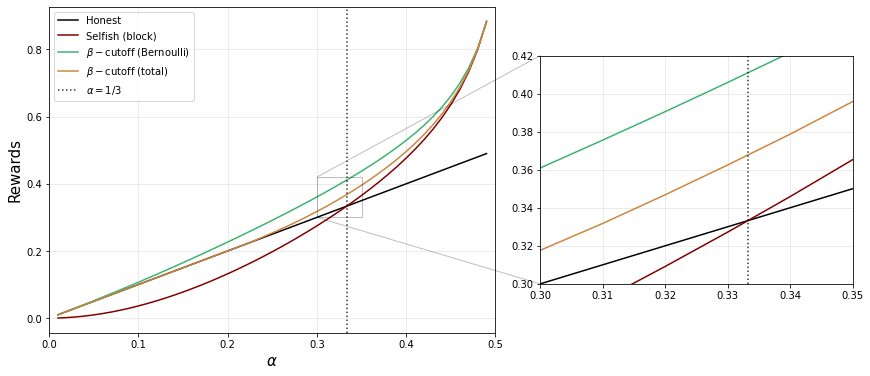

In [687]:
f, ax = plt.subplots(figsize=(8,6))


axins = ax.inset_axes(
    [1.1, 0.15, 0.7, 0.7],
    xlim=(.3, .35), ylim=(0.3, 0.42))

ax.indicate_inset_zoom(axins, edgecolor="black", label=None, alpha=0.25)


for ax_ in [ax, axins]:
    ax_.plot(alphas, alphas, label='Honest', color='black')
    ax_.plot(alphas, selfish_rews, label='Selfish (block)', color='maroon')
    ax_.plot(alphas, bern_rews, label=r'$\beta-$cutoff (Bernoulli)', color='mediumseagreen')
    ax_.plot(alphas, total_rews/3, label=r'$\beta-$cutoff (total)', color='peru')
    ax_.grid(alpha=0.3)
    ax_.axvline(1/3, color='k', alpha=0.8, label=r'$\alpha=1/3$', linestyle='dotted')

ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'Rewards', size=15)
ax.set_xlim(0,0.5)

ax.legend(loc=2)
plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# sims

In [695]:
alphas    = [0.2, 0.25, 0.3, 0.35, 0.4]
betas     = np.arange(1.751, 4, 0.01)
gammas = [0.0, 0.5, 1.0]
p_     = 0.5
E_     = 1.
C_     = 1.
g_     = 0.

subs = {C:C_, E:E_, p:p_, g:g_}

In [693]:
attack_fixed = attack_full_fixed.subs({p1:p1_sym}).subs(subs)
attack_bern  = attack_full_bern.subs({p1:p1_sym}).subs(subs)
attack_lin   = attack_full_lin.subs({p1:p1_sym}).subs(subs)

In [705]:
o_0p    = 1
o_rest = p1*a*(1-a)/(1-2*a)
orphan_full = p0p * o_0p + o_rest
eq1 = sp.Eq(orphan_full.subs({p1:p1_sym}).subs(subs), ell)

In [709]:
theo_res_fixed = []
for a_ in tqdm(alphas):
    temp1 = []
    for b_ in betas:
        ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
        attack = attack_fixed.subs({a:a_, b:b_, p:p_, ell:ell_})
        temp1.append(attack)
    theo_res_fixed.append(temp1)
theo_res_fixed = np.array(theo_res_fixed)
theo_res_fixed.shape

100%|██████████| 5/5 [00:33<00:00,  6.73s/it]


(5, 225)

In [713]:
theo_res_bern = []
for a_ in tqdm(alphas):
    temp1 = []
    for b_ in betas:
        ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
        attack = attack_bern.subs({a:a_, b:b_, p:p_, ell:ell_})
        temp1.append(attack)
    theo_res_bern.append(temp1)
theo_res_bern = np.array(theo_res_bern)
theo_res_bern.shape

100%|██████████| 5/5 [00:34<00:00,  6.81s/it]


(5, 225)

In [717]:
theo_res_lin = []
for a_ in tqdm(alphas):
    temp1 = []
    for b_ in betas:
        ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
        attack = (1/(1-ell_))*attack_lin.subs({a:a_, b:b_, p:p_, ell:ell_})
        temp1.append(attack)
    theo_res_lin.append(temp1)
theo_res_lin = np.array(theo_res_lin)
theo_res_lin.shape

100%|██████████| 5/5 [00:34<00:00,  6.90s/it]


(5, 225)

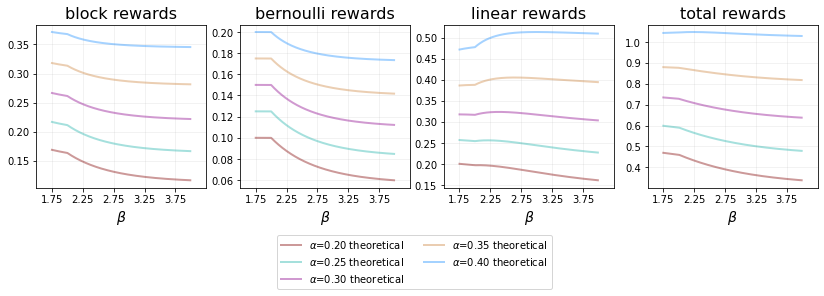

In [719]:
f, axarr = plt.subplots(nrows=1, ncols=4, figsize=(14,3))

colors = ['maroon', 'lightseagreen', 'darkmagenta', 'peru', 'dodgerblue'] 


ax = axarr[0]
for j, a_ in enumerate(alphas):
    axarr[0].plot(betas, theo_res_fixed[j,:], linewidth=2, color=colors[j], alpha=0.4,
                  label=r'$\alpha$={:0.2f} theoretical'.format(a_))
    axarr[1].plot(betas, theo_res_bern[j,:], linewidth=2, color=colors[j], alpha=0.4,
                  label=r'$\alpha$={:0.2f} theoretical'.format(a_))
    axarr[2].plot(betas, theo_res_lin[j,:], linewidth=2, color=colors[j], alpha=0.4,
                  label=r'$\alpha$={:0.2f} theoretical'.format(a_))
    
    total_theo_rews = theo_res_fixed[j,:]+theo_res_bern[j,:]+theo_res_lin[j,:]
    axarr[3].plot(betas, total_theo_rews, linewidth=2, color=colors[j], alpha=0.4,
                  label=r'$\alpha$={:0.2f} theoretical values'.format(a_))



# ax = axarr[0]
# for j, a_ in enumerate(alphas):
#     marker, = ax.plot(sim_betas, sim_res_fixed[j,:,0], marker='o', color=colors[j], linestyle='none', 
#                       fillstyle='none', label=r'$\alpha$={:0.2f} simulation values'.format(a_))
# ax = axarr[1]
# for j, a_ in enumerate(alphas):
#     marker, = ax.plot(sim_betas, sim_res_bern[j,:,0], marker='o', color=colors[j], linestyle='none', 
#                       fillstyle='none', label=r'$\alpha$={:0.2f} simulation values'.format(a_))
# ax = axarr[2]
# for j, a_ in enumerate(alphas):
#     marker, = ax.plot(sim_betas, sim_res_lin[j,:,0], marker='o', color=colors[j], linestyle='none', 
#                       fillstyle='none', label=r'$\alpha$={:0.2f} simulation values'.format(a_))

# for j, a_ in enumerate(alphas):
#     total_rews = theo_res_fixed[j,:,0]+theo_res_bern[j,:,0]+theo_res_lin[j,:,0]
#     axarr[3].plot(betas, total_rews, linewidth=2, color=colors[j], alpha=0.4,
#                   label=r'$\alpha$={:0.2f} theoretical values'.format(a_))
    
#     total_sim_rews = sim_res_fixed[j,:,0]+sim_res_bern[j,:,0]+sim_res_lin[j,:,0]
#     marker, = axarr[3].plot(sim_betas, total_sim_rews, marker='o', color=colors[j], linestyle='none', 
#                       fillstyle='none', label=r'$\alpha$={:0.2f} simulation values'.format(a_))
    

axarr[0].set_title(r'block rewards', size=16)
axarr[1].set_title(r'bernoulli rewards', size=16)
axarr[2].set_title(r'linear rewards', size=16)
axarr[3].set_title(r'total rewards', size=16)

for i, ax in enumerate(axarr):
    ax.grid(alpha=0.2)
    ax.set_xlim(1.5, 4.25)
    ax.set_xticks(np.arange(1.75,4.01,0.5))
    ax.set_xlabel(r'$\beta$', size=14)
    
handles, labels = axarr[0].get_legend_handles_labels()
f.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.07), ncol=2)


plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [114]:
n=int(5e5)
sim_betas = np.arange(1.751, 4.1, 0.25)
sim_betas

array([1.751, 2.001, 2.251, 2.501, 2.751, 3.001, 3.251, 3.501, 3.751,
       4.001])

In [115]:
sim_res_fixed = []
sim_res_bern  = []
sim_res_lin   = []
for a_ in alphas:
    temp1_fixed = []
    temp1_bern  = []
    temp1_lin  = []
    for b_ in tqdm(sim_betas):
        temp2_fixed = []
        temp2_bern  = []
        temp2_lin  = []
        for p_ in ps:
            honestBlc, attackBlc, honestBer, attackBer, honestLin, attackLin, time = simAllRews(
                a=a_, b=b_, g=0., p=p_, C=1., E=1., n=n)
            temp2_fixed.append(attackBlc/time)
            temp2_bern.append(attackBer/time)
            temp2_lin.append(attackLin/time)
        temp1_fixed.append(temp2_fixed)
        temp1_bern.append(temp2_bern)
        temp1_lin.append(temp2_lin)
    sim_res_fixed.append(temp1_fixed)
    sim_res_bern.append(temp1_bern)
    sim_res_lin.append(temp1_lin)
sim_res_fixed = np.array(sim_res_fixed)
sim_res_bern = np.array(sim_res_bern)
sim_res_lin = np.array(sim_res_lin)
sim_res_fixed.shape, sim_res_bern.shape, sim_res_lin.shape

100%|██████████| 10/10 [00:28<00:00,  2.84s/it]


((5, 10, 1), (5, 10, 1), (5, 10, 1))

In [73]:
# simluation code
def simAllRews(a, b, g, p, C, E, n):
    gamma = g
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    honestBern = 0
    attackBern = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0
    prevBern   = 0
    for _ in range(n):
        attBlock = np.random.binomial(1, a)
        execRews = np.random.exponential()
        bernRews = np.random.binomial(1, p=p)
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                if bernRews and execRews < (b-C-E):
                    state      = [1,0]
                    lastAttBlc = curTime
                    prevBern   = bernRews
                elif not bernRews and execRews < b-C:
                    state      = [1,0]
                    lastAttBlc = curTime
                    prevBern   = 0
                else:
                    attackBlcs += 1*C
                    attackRews += execRews
                    attackBern += bernRews
                    lastState0  = curTime
                    lastAttBlc  = curTime
            else:
                honestBlcs += 1*C
                honestRews += execRews
                honestBern += bernRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
                attackBern += bernRews + prevBern
                prevBern   = 0
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                nextBern      = np.random.binomial(1, p=p)
                if sample < a:
                    attackBlcs += 2*C
                    attackRews += (curTime - lastState0) + nextExecRews
                    attackBern += (prevBern + nextBern)
                elif sample <= a + ((1-a)*gamma):
                    attackBlcs += 1*C
                    honestBlcs += 1*C
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                    attackBern += prevBern
                    honestBern += nextBern
                else:
                    honestBlcs += 2*C
                    honestRews += (curTime - lastState0) + nextExecRews
                    # honest bern is a random trial
                    prevHonest  = np.random.binomial(1, p=p)
                    honestBern += (prevHonest + nextBern)
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                prevBern    = 0
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]*C
            if state[0] < 2:
                raise KeyError("here")
            attackBern += (state[0]-2) * p
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, a)
            execRews = np.random.exponential()
            bernRews = np.random.binomial(1, p=p)
            curTime += execRews
            if attBlock:
                attackBlcs += 1*C
                attackRews += (remRews + execRews)
                attackBern += bernRews
            else:
                honestBlcs += 1*C
                honestRews += (remRews + execRews)
                honestBern += bernRews

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]
 
    return honestBlcs, attackBlcs, honestBern, attackBern, honestRews, attackRews, curTime